Reference
- Prediction, learning, and games
Cesa-Bianchi, Nicolo, 1963-; Lugosi, Gabor.; Nicolo Cesa-Bianchi, Gabor Lugosi.
Chapter 2 Prediction with Expert Advice

# Task1: Exponentially Weighted Average Forecaster VS Polynomially Weighted Average Forecaster

This script compares two online prediction algorithms—the Polynomially Weighted Average Forecaster (PWAF) and the Exponentially Weighted Average Forecaster (EWAF)—in a simulated setting using square loss.

1. PWAF (Polynomially Weighted Average Forecaster):

- Maintains cumulative regret (how much worse the forecaster does compared to each expert).

- Uses polynomial potential to compute expert weights based on past regrets.

2. EWAF (Exponentially Weighted Average Forecaster):

- Maintains cumulative loss for each expert.

- Uses exponential weighting based on loss history.

3. Simulation Setup:

- N = 10 experts, T = 100 time steps.

- At each time step:

- - Experts give random predictions.

- - A random true label is generated.

- - Both forecasters make a prediction.

- - Loss is computed using squared error.

- - The forecasters are updated.

- - Regret is calculated as the difference between the system's loss and the average expert loss.

4. Evaluation:

- Tracks and plots the cumulative regret over time for both methods.

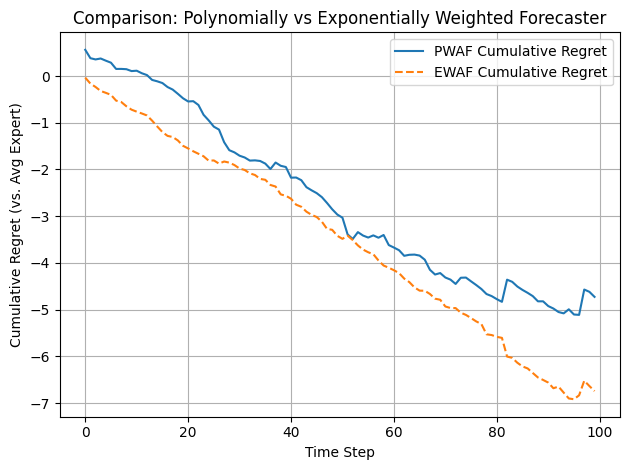

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Polynomially Weighted Average Forecaster (PWAF)
# ----------------------------

class PolynomiallyWeightedAverageForecaster:
    def __init__(self, num_experts, p=2):
        self.N = num_experts  # number of experts
        self.p = p
        self.R = np.zeros(self.N)  # cumulative regret vector for each expert

    def _positive_part(self, x):
        return np.maximum(x, 0)

    def _polynomial_potential(self, u):
        """ Φ_p(u) = ||u_+||_p^2 """
        u_plus = self._positive_part(u)
        return np.linalg.norm(u_plus, ord=self.p) ** 2

    def _weights(self):
        """ Compute w_i,t-1 based on ∇Φ_p """
        R_plus = self._positive_part(self.R)
        numerator = 2 * R_plus ** (self.p - 1)
        denominator = (np.linalg.norm(R_plus, ord=self.p)) ** (self.p - 2)
        return numerator / denominator

    def loss(self, pred, true):
        # Example: square loss as a convex function
        return (pred - true) ** 2

    def predict(self, expert_predictions, history_preds, history_labels):
        """
        expert_predictions: array of shape (N,) for current step predictions f_{i,t}
        history_preds: list of system predictions [p̂_1, ..., p̂_{t-1}]
        history_labels: list of true labels [y_1, ..., y_{t-1}]
        """
        N, p = self.N, self.p
        regrets = np.zeros(N)

        for i in range(N):
            regret_sum = 0
            for s in range(len(history_preds)):
                system_loss = self.loss(history_preds[s], history_labels[s])
                expert_loss = self.loss(expert_predictions[i], history_labels[s])
                regret_sum += system_loss - expert_loss
            regrets[i] = max(regret_sum, 0)

        weights = regrets ** (p - 1)
        weighted_sum = np.dot(weights, expert_predictions)
        prediction = weighted_sum / (np.sum(weights) + 1e-8)  # add epsilon to avoid divide-by-zero

        # update cumulative regret R for next time
        self.R = regrets

        return prediction

# ----------------------------
# Exponentially Weighted Average Forecaster (EWAF)
# ----------------------------
class ExponentiallyWeightedAverageForecaster:
    def __init__(self, num_experts, eta=1.0):
        self.N = num_experts  # number of experts
        self.eta = eta
        self.L = np.zeros(self.N)  # cumulative loss for each expert

    def _exponential_potential(self, u):
        """ Φ_η(u) = (1/η) * log(sum(exp(η * u))) """
        return (1 / self.eta) * np.log(np.sum(np.exp(self.eta * u)))

    def _weights(self):
        """ Compute w_i,t-1 based on ∇Φ_η (using cumulative loss vector) """
        exp_weights = np.exp(-self.eta * self.L)
        return exp_weights / (np.sum(exp_weights) + 1e-8)  # normalize, avoid divide-by-zero

    def loss(self, pred, true):
        # Example: square loss as a convex function
        return (pred - true) ** 2

    def update(self, expert_predictions, true_label):
        """
        Update cumulative loss vector L after observing true label y_t, this will also update the weights.
        """
        losses = np.array([self.loss(f, true_label) for f in expert_predictions])
        self.L += losses

    def predict(self, expert_predictions):
        """
        expert_predictions: array of shape (N,) for current step predictions f_{i,t}
        returns: system prediction p̂_t
        """
        weights = self._weights()
        prediction = np.dot(weights, expert_predictions)
        return prediction

# ----------------------------
# Simulation setup
# ----------------------------
np.random.seed(0)
N = 10       # number of experts
T = 100      # number of time steps
p = 2
eta = 1.0

poly_forecaster = PolynomiallyWeightedAverageForecaster(num_experts=N, p=p)
exp_forecaster = ExponentiallyWeightedAverageForecaster(num_experts=N, eta=eta)

expert_predictions_history = []
poly_preds = []
exp_preds = []
true_labels = []

poly_cum_regret = []
exp_cum_regret = []

for t in range(T):
    expert_preds = np.random.rand(N)         # expert predictions
    true_label = np.random.rand()            # true label

    pt_poly = poly_forecaster.predict(expert_preds, poly_preds, true_labels)
    pt_exp = exp_forecaster.predict(expert_preds)
    exp_forecaster.update(expert_preds, true_label)

    poly_preds.append(pt_poly)
    exp_preds.append(pt_exp)
    true_labels.append(true_label)
    expert_predictions_history.append(expert_preds)

    expert_losses = [((fp - true_label) ** 2) for fp in expert_preds]
    avg_expert_loss = np.mean(expert_losses)

    poly_loss = (pt_poly - true_label) ** 2
    exp_loss = (pt_exp - true_label) ** 2

    poly_cum_regret.append(poly_loss - avg_expert_loss)
    exp_cum_regret.append(exp_loss - avg_expert_loss)

# ----------------------------
# Visualization
# ----------------------------
plt.plot(np.cumsum(poly_cum_regret), label="PWAF Cumulative Regret")
plt.plot(np.cumsum(exp_cum_regret), label="EWAF Cumulative Regret", linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Regret (vs. Avg Expert)")
plt.title("Comparison: Polynomially vs Exponentially Weighted Forecaster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusion**：

This experiment simulates a realistic online learning scenario where a system has to make predictions based on expert advice.

The code demonstrates that both forecasters adapt over time, but their regret grows differently.

By comparing their cumulative regret curves, we can visually assess which method performs better under the same conditions.

EWAF usually grows more slowly in regret, confirming its theoretical advantage in many settings.

# Task2 Compare the theoretical regret upper bounds of two online learning algorithms:

Polynomially Weighted Average Forecaster (PWAF)

Exponentially Weighted Average Forecaster (EWAF)

Parameters used:

N = 100: number of experts.

n ranges from 10 to 10,000: representing the number of prediction rounds.

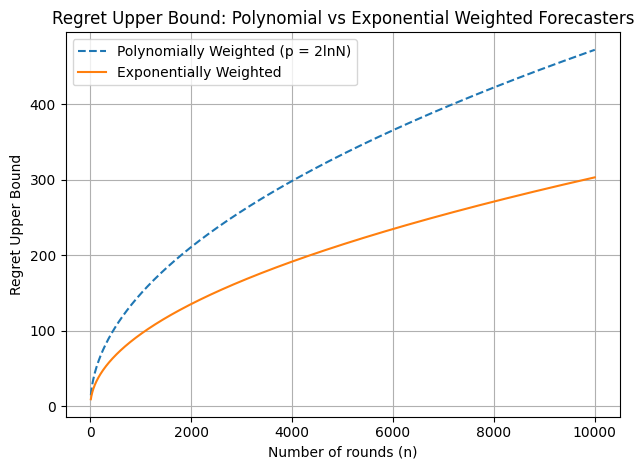

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter settings
N = 100  # Number of experts
n_range = np.arange(10, 10001, 10)  # Number of rounds from 10 to 10,000, sampled every 10

# Store the theoretical regret upper bound for each n
p = 2 * np.log(N)
pwaf_bounds = []  # Polynomial bound
ewaf_bounds = []  # Exponential bound

for n in n_range:
    # Polynomially Weighted: sqrt(n * (p - 1) * N^(2/p))
    pwaf = np.sqrt(n * (p - 1) * N ** (2 / p))
    pwaf_bounds.append(pwaf)

    # Exponentially Weighted: sqrt(2 * n * ln N)
    ewaf = np.sqrt(2 * n * np.log(N))
    ewaf_bounds.append(ewaf)

# Plotting
#plt.figure(figsize=(10, 6))
plt.plot(n_range, pwaf_bounds, label='Polynomially Weighted (p = 2lnN)', linestyle='--')
plt.plot(n_range, ewaf_bounds, label='Exponentially Weighted', linestyle='-')
plt.xlabel("Number of rounds (n)")
plt.ylabel("Regret Upper Bound")
plt.title("Regret Upper Bound: Polynomial vs Exponential Weighted Forecasters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Result**:  

The plot shows how the regret upper bound grows as the number of rounds increases.

EWAF has a slower growth rate, indicating a tighter (better) theoretical upper bound on regret.

PWAF grows faster, implying that its worst-case performance can be worse in longer prediction horizons.

# Tunning p in Polynomially Weighted Average Forecaster

This code investigates how different values of the parameter `p` affect the theoretical **regret upper bound** of the Polynomially Weighted Average Forecaster (PWAF). It explores three choices:

- `p = 2`  
- `p = 4`  
- `p = 2 ln(N)` (the recommended value from theory)

The regret upper bound is calculated using the formula:

$$
\text{bound}(p) = \sqrt{n (p - 1) \cdot N^{2/p}}
$$

In addition, a tighter theoretical bound is calculated when `p = 2 ln(N)`, using the formula:

$$
\text{tight_bound} = \sqrt{n e \cdot (2 \ln N - 1)}
$$

This helps compare the theoretical performance of different choices of `p` and provides insight into how well the recommended value performs in theory.


In [22]:
# Parameter settings
n = 200         # total number of prediction rounds
N = 10          # number of experts
p_list = [2, 4, 2 * np.log(N)]  # trying different values of p
p_labels = ['p=2', 'p=4', 'p=2ln(N)']

# Calculate the theoretical upper bound for each value of p
regret_bounds = []
for p in p_list:
    bound = np.sqrt(n * (p - 1) * N ** (2 / p))
    regret_bounds.append(bound)

# Additionally calculate a tighter bound (formula 2)
tight_bound = np.sqrt(n * np.e * (2 * np.log(N) - 1))

# Print results
print("Regret Upper Bounds for Polynomially Weighted Forecaster:")
for label, bound in zip(p_labels, regret_bounds):
    print(f"{label:10s}: {bound:.4f}")

print(f"\nTighter bound when p = 2ln(N): {tight_bound:.4f}")


Regret Upper Bounds for Polynomially Weighted Forecaster:
p=2       : 44.7214
p=4       : 43.5588
p=2ln(N)  : 44.2716

Tighter bound when p = 2ln(N): 44.2716


**Result**:  
- The code prints out the regret upper bounds for each selected value of `p`.
- It shows that the regret bound **varies with the choice of `p`**.
- The tighter bound computed for `p = 2 ln(N)` serves as a benchmark from the literature.
- While the theory suggests that `p = 2 ln(N)` is a good choice, this experiment shows that it may not always yield the **lowest bound** among all possible values of `p`.

**Conclusion**:  
It's useful to **tune the parameter `p`** based on the specific setting rather than relying solely on the theoretical recommendation. The tighter bound provides a theoretical minimum that helps assess the quality of different choices.